In [1]:
!lscpu | egrep 'Model name|Socket|Thread|NUMA|CPU\(s\)'

'lscpu'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.


In [2]:
!lspci | grep VGA

'lspci'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.


In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1' # 사용하려는 GPU 번호
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import IPython.display as ipd
%matplotlib inline

In [4]:
#상수 설정
SCALE =False

In [5]:
train = pd.read_csv('train.csv')
test= pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

In [6]:
def split_date(df):
    df['year'] =pd.to_datetime(df['date_time']).dt.year
    
    df['month'] =pd.to_datetime(df['date_time']).dt.month
    df['day']= pd.to_datetime(df['date_time']).dt.day
    df['week']= pd.to_datetime(df['date_time']).dt.week
    df['weekday']= pd.to_datetime(df['date_time']).dt.weekday

    return df.drop(columns=['date_time'])


In [7]:
train_df= split_date(train)
test_df= split_date(test)


In [8]:
keys = train_df.drop(columns=['number_of_rentals']).keys()

AttributeError: 'Index' object has no attribute 'info'

In [10]:
train.head()

,date_time,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,number_of_rentals,year,month,day,week,weekday
0,2018-04-01,207.500,4.000,0.000,3.050,75.000,12.600,21.000,30.000,22994,2018,4,1,13,6
1,2018-04-02,208.317,2.950,0.000,3.278,69.833,12.812,19.000,19.500,28139,2018,4,2,14,0
2,2018-04-03,213.516,2.911,0.000,2.690,74.879,10.312,15.316,19.113,26817,2018,4,3,14,1
3,2018-04-04,143.836,3.692,0.425,3.138,71.849,8.312,12.368,43.493,26034,2018,4,4,14,2
4,2018-04-05,95.905,4.000,0.723,3.186,73.784,5.875,10.421,63.378,2833,2018,4,5,14,3


In [11]:
test.head()

,date_time,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,year,month,day,week,weekday
0,2021-04-01,108.833,3.000,0.000,2.900,28.333,11.800,20.667,18.333,2021,4,1,13,3
1,2021-04-02,116.717,3.850,0.000,2.662,46.417,12.000,19.000,28.500,2021,4,2,13,4
2,2021-04-03,82.669,4.000,0.565,2.165,77.258,8.875,16.368,52.847,2021,4,3,13,5
3,2021-04-04,44.123,3.466,0.466,3.747,63.288,6.250,17.368,37.671,2021,4,4,13,6
4,2021-04-05,147.791,1.500,0.000,1.560,48.176,7.188,18.684,4.459,2021,4,5,14,0


In [12]:
keydict=dict()
for i, k, in enumerate(keys):
    keydict[i]=k
    

In [13]:
X= np.array(train_df.drop(columns=['number_of_rentals'])).astype(float)
y= np.array(train_df['number_of_rentals']).astype(float)
X_test = np.array(test_df).astype(float)

if SCALE:
    x_max =np.max(X,0)
    y_max =np.max(y,0)
    X/=x_max
    y/=y_max
    X_test/=x_max

In [24]:
X

array([[2.07500e+02, 4.00000e+00, 0.00000e+00, ..., 1.00000e+00,
        1.30000e+01, 6.00000e+00],
       [2.08317e+02, 2.95000e+00, 0.00000e+00, ..., 2.00000e+00,
        1.40000e+01, 0.00000e+00],
       [2.13516e+02, 2.91100e+00, 0.00000e+00, ..., 3.00000e+00,
        1.40000e+01, 1.00000e+00],
       ...,
       [2.82568e+02, 1.73000e+00, 0.00000e+00, ..., 2.80000e+01,
        2.60000e+01, 6.00000e+00],
       [1.37027e+02, 2.25700e+00, 8.80000e-02, ..., 2.90000e+01,
        2.70000e+01, 0.00000e+00],
       [1.20797e+02, 3.62200e+00, 4.32000e-01, ..., 3.00000e+01,
        2.70000e+01, 1.00000e+00]])

In [14]:
def nmae(true, pred):
    return np.mean(np.abs(true-pred/true))

In [15]:
def cv(model, X=X,y=y, cnt=100, test_size=.5):
    score=list()
    seeds=np.random.choice(np.arange(1e5), size=cnt, replace=False)
    for seed in seeds:
        X_train, X_valid, y_train, y_valid =train_test_split(X,y, test_size=test_size)
        model.fit(X_train,y_train)
        y_pred = model.predict(X_valid)
        if SCALE:
            y_pred *=y_max
            y_valid*=y_max

        score.append(nmae(y_valid, y_pred))
    
    return np.mean(score)
    

In [16]:
def select_features(X, cols):
    _X=list()
    for c in cols:
        _X.append(np.expand_dims(X[:,c],-1))
    return np.concatenate(_X, axis=1)

In [17]:
keydict

{0: 'wind_direction',
 1: 'sky_condition',
 2: 'precipitation_form',
 3: 'wind_speed',
 4: 'humidity',
 5: 'low_temp',
 6: 'high_temp',
 7: 'Precipitation_Probability',
 8: 'year',
 9: 'month',
 10: 'day',
 11: 'week',
 12: 'weekday'}

In [18]:
from xgboost import XGBRegressor as Model

min_loss= 1e10
min_cols =None

for i in np.arange(start=0, stop=len(keys)):
    model = Model(tree_mothod='gpu_hist')
    cols =np.arange(len(keys))
    cols=np.delete(cols,i)
    _X = select_features(X,cols)
    loss = cv(model,_X,y,cnt=30)
    if min_loss > loss:
        min_loss=loss
        min_cols = f"{keydict.get(i)}"
    
    print(f"{keydict.get(i)}, {loss:.4f}(min{min_loss:.4f})")

[16:50:10] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { tree_mothod } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:50:10] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { tree_mothod } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:50:10] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { tree_mothod } might not be used.

  This may not be accurate due to some parameters are only used in langu

[16:50:21] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { tree_mothd } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




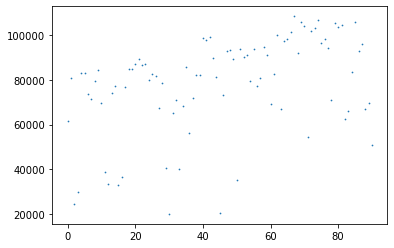

In [19]:
import matplotlib.pyplot as plt
model = Model(tree_mothd ='gpu_hist')

cols =np.arange(len(keys))
cols = np.delete(cols, [0,7])
_X = select_features(X,cols)

model.fit(_X,y)

_X_test = select_features(X_test, cols)
y_pred = model.predict(_X_test)

if SCALE:
    y_pred *=y_max
y_pred =y_pred.astype(int)

plt.scatter(np.arange(len(y_pred)),y_pred, s=.5)
plt.show()
